# Задача классификации

## Загружаем данные

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [2]:
import zipfile

path = "archive.zip"

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall("")

Kaggle, кажется, не предоставляет прямой ссылки на файл данных. Скачиваем, распаковываем и читаем датафрейм с компьютера

In [3]:
# url = "https://www.kaggle.com/tjkyner/chicago-food-inspections?select=Food_Inspections.csv"
data_raw = pd.read_csv("Food_Inspections.csv")

In [4]:
type(data_raw)

pandas.core.frame.DataFrame

This information is derived from inspections of restaurants and other food
establishments in Chicago from January 1, 2010 to the present. Inspections are performed by
staff from the Chicago Department of Public Health’s Food Protection Program. Inspections are
done using a standardized procedure. The results of the inspection are inputted into a database,
then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner
(LEHP). A subset of data elements are extracted from this database and downloaded into this
data portal

In [5]:
data_raw.shape

(221468, 17)

In [6]:
data_raw.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2492889,Kozminski,Kozminski,31151.0,School,Risk 1 (High),936 E 54th St (5400S),CHICAGO,IL,60615.0,03/15/2021,Canvass,Pass,NaN,41.798029,-87.602463,"(-87.60246286753599, 41.798029497076946)"
1,2484532,VOLARE,VOLARE,2141813.0,Restaurant,Risk 1 (High),201 E GRAND AVE,CHICAGO,IL,60611.0,02/04/2021,Non-Inspection,No Entry,NaN,41.891652,-87.622604,"(-87.62260381408842, 41.89165221441017)"
2,2472891,MIMI'S TACOS,MIMI'S TACOS,2766681.0,Restaurant,Risk 1 (High),570-572 W ROOSEVELT RD,CHICAGO,IL,60607.0,01/20/2021,License,Not Ready,NaN,41.867330,-87.642117,"(-87.64211742912265, 41.86733048241842)"
3,2472503,WESTERN CAFE,WESTERN CAFE,2487565.0,Restaurant,Risk 1 (High),5710 N WESTERN AVE,CHICAGO,IL,60659.0,01/11/2021,Canvass,Out of Business,NaN,41.985362,-87.689652,"(-87.68965150838075, 41.9853615288893)"
4,2472385,HILLTOP FAMILY RESTAURANT,HILLTOP FAMILY RESTAURANT,2652370.0,Restaurant,Risk 1 (High),2800 W FOSTER AVE,CHICAGO,IL,60625.0,01/07/2021,Non-Inspection,No Entry,NaN,41.975927,-87.699046,"(-87.69904568571212, 41.97592670619184)"


## Определим классы

Рассматривать в качестве классов будем результаты проверки. Посмотрим, какие они бывают.

In [7]:
data_raw['Results'].unique()

array(['Pass', 'No Entry', 'Not Ready', 'Out of Business', 'Fail',
       'Pass w/ Conditions', 'Business Not Located'], dtype=object)

Однако про данные указано, что:
> **Results**: An inspection can pass, pass with conditions or fail. Establishments receiving a
‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-
29, respectively). Establishments receiving a ‘pass with conditions’ were found to have
critical or serious violations, but these were corrected during the inspection.
Establishments receiving a ‘fail’ were found to have critical or serious violations that
were not correctable during the inspection. An establishment receiving a ‘fail’ does not
necessarily mean the establishment’s licensed is suspended. Establishments found to
be out of business or not located are indicated as such.

Действительно, часть возможных результатов основывается не на имеющихся в датафрейме данных. Таким образом, можно выделить 3 класса, которые можно определить по прочим признакам: *'Pass'*, *'Pass w/ Conditions'*, *'Fail'*. Строки с другими результатами удалим.


In [8]:
data = data_raw[(data_raw['Results'] == "Pass") | (data_raw['Results'] == "Fail") | (data_raw['Results'] == "Pass w/ Conditions")].copy()
data.shape

(192061, 17)

Покажем, что классы не сбалансированы

In [9]:
data['Results'].value_counts(normalize=True)

Pass                  0.601168
Fail                  0.222237
Pass w/ Conditions    0.176595
Name: Results, dtype: float64

### Заменим строковые данные числами

Смотрим, какие значения принимает **Risk**

In [10]:
data['Risk'].unique()

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)', nan, 'All'],
      dtype=object)

Заменим числовыми значениями

In [11]:
data['Risk'] = data['Risk'].replace(to_replace ='.*(\d).*', value = '\g<1>', regex = True)
#data_raw['Risk'].astype(np.int32)
data['Risk']

0         1
11        1
12        1
15        1
16        1
         ..
221463    1
221464    1
221465    2
221466    2
221467    3
Name: Risk, Length: 192061, dtype: object

И не забудем про *all*. Описание данных ничего не говорит нам о значении *all*. 
> **Risk category of facility:**  Each establishment is categorized as to
> its risk of adversely  
>     affecting the public’s health, with 1 being the highest and 3 the lowest. The frequency of  
>     inspection is tied to this risk, with risk 1 establishments inspected most frequently and  
>     risk 3 least frequently.

Следовательно строки с all не берём

In [12]:
rows_to_drop = data[(data['Risk'] == "All")].index
data = data.drop(rows_to_drop)
data.shape
# rows_to_drop

(192056, 17)

In [13]:
data['Risk'] = data['Risk'].astype('float')

In [14]:
for str in ['Facility Type', 'Inspection Type', 'Results']:
    data[str] = data[str].astype('category')

In [15]:
data.describe()

,Inspection ID,License #,Risk,Zip,Latitude,Longitude
count,1.920560e+05,1.920400e+05,192022.000000,192024.000000,191353.000000,191353.000000
mean,1.533368e+06,1.628621e+06,1.337769,60628.618667,41.880396,-87.676203
std,6.847017e+05,9.128008e+05,0.608173,123.355297,0.081130,0.059248
min,4.424700e+04,0.000000e+00,1.000000,10014.000000,41.644670,-87.914428
25%,1.166310e+06,1.228416e+06,1.000000,60614.000000,41.831075,-87.707109
50%,1.537356e+06,1.999098e+06,1.000000,60625.000000,41.891279,-87.665571
75%,2.135944e+06,2.283206e+06,2.000000,60643.000000,41.939654,-87.634531
max,2.521547e+06,9.999999e+06,3.000000,60827.000000,42.021064,-87.525094


## Пропущенные значения

In [16]:
data.isna().sum()

Inspection ID          0
DBA Name               0
AKA Name            1736
License #             16
Facility Type        645
Risk                  34
Address                0
City                 125
State                 45
Zip                   32
Inspection Date        0
Inspection Type        1
Results                0
Violations         30494
Latitude             703
Longitude            703
Location             703
dtype: int64

Отсутствующих значений для *Facility Type* и *Inspection Type* не так много относительно общего количества строк. Кроме того, отсутствие номера лицензии не внушает доверия результату проверки. Просто удалим соответствующие строки.

In [17]:
rows_to_drop = data[(data['Facility Type'].isna()) | (data['Inspection Type'].isna()) | (data['License #'].isna())].index
data = data.drop(rows_to_drop)
data.shape

(191394, 17)

Глянем *Violations*. Пустые значения должны как правило означать отсутствие нарушений и пусты не по ошибке, поэтому удалять строки мы не будем.

In [18]:
data.at[221463, 'Violations']

'34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    FLOORS IN NEED OF CLEANING TO REMOVE BUILD-UP. MUST CLEAN AND MAINTAIN. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: The walls and ceilings shall be in good repair and easily cleaned. Use dustless cleaning methods.    WALLS AND CEILINGS IN NEED OF CLEANING TO REMOVE FOOD AND DUST. MUST CLEAN AND MAINTAIN. | 38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: The flow of air discharged from kitchen fans shall always be through a duct to a point above the roofline. Ventilation: All plumbing fixtures, such as toilets, sinks, washbasins, etc., must be adequately trapped, vented, and re-vented and properly connected to the 

In [19]:
text = data.at[221463, 'Violations']
import re
regex_num = re.compile('\d+\.')  
regex_num.findall(text)  

['34.', '35.', '38.']

Попробуем разобрать эти значения. Добавим столбцы с номерами возможных нарушений.

> **Violations**: An establishment can receive one or more of 45 distinct violations (violation
numbers 1-44 and 70). For each violation number listed for a given establishment, the
requirement the establishment must meet in order for it to NOT receive a violation is
noted, followed by a specific description of the findings that caused the violation to be
issued.

In [20]:
regex_num = re.compile('(?:(?<=^)|(?<=\| ))\d+\.') 
for i, row in data.iterrows():    
    violations = regex_num.findall(f"{row['Violations']}") 
    #print(violations)
    
    for violation in violations:
        data.at[i, violation] = 1
    

In [21]:
data.at[15, 'Violations']

'3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: SEE VIOLATION #60.  | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: MUST PROVIDE HAND WASHING SIGNAGE AT ALL WASHBOWL AND HAND WASHING SINKS.\t | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: OBSERVED EXCESSIVE AMOUNT OF BLACK AND BROWN, SLIMY, MOLD-LIKE SUBSTANCES THROUGHOUT INTERIOR OF ICE MACHINE, AND COMING IN CONTACT WITH ICE. MUST REMOVE SUBSTANCE, DETAIL CLEAN AND SANITIZE MACHINE. PRIORITY FOUNDATION VIOLATION 7-38-005. CITATION ISSUED.  | 35. APPROVED THAWING METHODS USED - Comments: OBSERVED IMPROPER THAWING METHOD IN USE. OBSERVED FISH AND CRAB SITTING IN STANDING WATER IN 3 COMPARTMENT SINK. (CRAB @ 38.8F AND FISH @ 41F)INSTRUCTED MUST USE ONE OF THE FOLLOWING APPROVED METHOD FOR THAWING: IN REFRIGERATION, IN A MICROWAVE AS PART OF A CONTINUOUS COOKING PROCESS, OR COMPLETELY SUBMERGED UNDER RUNNING WATER WITH SUFFICIENT WAT

In [22]:
data['3.']

0         NaN
11        NaN
12        NaN
15        1.0
16        NaN
         ... 
221463    NaN
221464    NaN
221465    NaN
221466    NaN
221467    NaN
Name: 3., Length: 191394, dtype: float64

In [23]:
data.iloc[:, 17:] = data.iloc[:, 17:].fillna(0, axis = 0)
data.iloc[:, 16:]

,Location,3.,10.,16.,35.,36.,37.,47.,53.,55.,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
0,"(-87.60246286753599, 41.798029497076946)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,"(-87.72392832288558, 41.81310105112748)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,"(-87.61192836248603, 41.802049821529806)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,"(-87.74586369218258, 41.91399920930635)",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,"(-87.64299618172501, 41.896585191199556)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221463,"(-87.62602037433696, 41.8974381950521)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221464,"(-87.59902191495524, 41.655906736353224)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221465,"(-87.62517250873418, 41.883115221384855)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221466,"(-87.83684032683502, 41.9627679194481)",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
data['3.']

0         0.0
11        0.0
12        0.0
15        1.0
16        0.0
         ... 
221463    0.0
221464    0.0
221465    0.0
221466    0.0
221467    0.0
Name: 3., Length: 191394, dtype: float64

Столбец *Violations* можно теперь удалить. Вместе с ним и Location. Так как координаты уже записаны в отдельных столбцах.

In [25]:
data = data.drop('Violations', axis = 1)

In [26]:
data = data.drop('Location', axis = 1)

Пропущенные значения *AKA Name* скопируем с *DBA Name*

In [27]:
data['AKA Name'] = data['AKA Name'].fillna(data['DBA Name'])

In [28]:
data.iloc[:, :15].isna().sum()

Inspection ID        0
DBA Name             0
AKA Name             0
License #            0
Facility Type        0
Risk                15
Address              0
City               122
State               45
Zip                 31
Inspection Date      0
Inspection Type      0
Results              0
Latitude           698
Longitude          698
dtype: int64

Убедимся, что мы не переименовали по ошибке все строки, и заодно убедимся, что есть заведения, у которых отличаются официальное и общеизвестное название.

In [29]:
data[(data['DBA Name'] != data['AKA Name'])]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
40,2382667,STARBUCKS COFFEE # 216,STARBUCKS COFFEE,2398564.0,Restaurant,2.0,401 E ONTARIO ST,CHICAGO,IL,60611.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,2382213,WINGSTOP RESTAURANT,WINGSTOP,2570340.0,Restaurant,2.0,6024-6026 N BROADWAY AVE,CHICAGO,IL,60660.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2374199,CHOCOLATE CITY,DARK MATTER,2658208.0,Restaurant,2.0,2015 W GRAND AVE,CHICAGO,IL,60612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,2373373,UPTON'S NATURALS CO.,UPTON'S,2277659.0,Restaurant,1.0,2054 W GRAND AVE,CHICAGO,IL,60612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,2369855,Chicago Prep Master Tenant LLC,Chicago Prep Master Tenant,2723671.0,Shared Kitchen,1.0,5801 W Dickens AVE,CHICAGO,IL,60639.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221458,229220,Eurest Dining Services @ Credit Suisse Chicago,Credit Suisse Cafe,1488775.0,Restaurant,1.0,227 W MONROE ST,CHICAGO,IL,60606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221459,60390,MARISCOS BAHIA,"ELIAS TACOS, INCORPORATED",1488236.0,Restaurant,1.0,4465 S ARCHER AVE,CHICAGO,IL,60632.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221461,158244,"PARK PACKING OF CHICAGO, INC",PARK PACKING,2008956.0,Wholesale,2.0,1544 W 41ST ST,CHICAGO,IL,60609.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221462,72270,CHOP TOUHY,MAIN PIZZA CHALAVI,2021764.0,Restaurant,1.0,2931 W TOUHY AVE,CHICAGO,IL,60645.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Пропущенные значения в столбцах *City, State, Zip* заполним модой:

In [30]:
data['City'].fillna(data['City'].mode().iloc[0], inplace=True)
data['State'].fillna(data['State'].mode().iloc[0], inplace=True)
data['Zip'].fillna(data['Zip'].mode().iloc[0], inplace=True)

Пропущенные значения *Risk, Latitude, Longitude* заменим медианой.           

In [31]:
for col in ['Risk', 'Latitude', 'Longitude']:
    data[col].fillna(data[col].median(axis = 0), inplace=True)

In [32]:
data.iloc[:, :15].isna().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Results            0
Latitude           0
Longitude          0
dtype: int64

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191394 entries, 0 to 221467
Data columns (total 80 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Inspection ID    191394 non-null  int64   
 1   DBA Name         191394 non-null  object  
 2   AKA Name         191394 non-null  object  
 3   License #        191394 non-null  float64 
 4   Facility Type    191394 non-null  category
 5   Risk             191394 non-null  float64 
 6   Address          191394 non-null  object  
 7   City             191394 non-null  object  
 8   State            191394 non-null  object  
 9   Zip              191394 non-null  float64 
 10  Inspection Date  191394 non-null  object  
 11  Inspection Type  191394 non-null  category
 12  Results          191394 non-null  category
 13  Latitude         191394 non-null  float64 
 14  Longitude        191394 non-null  float64 
 15  3.               191394 non-null  float64 
 16  10.              191

In [34]:
data.describe(include=['category'])

,Facility Type,Inspection Type,Results
count,191394,191394,191394
unique,487,104,3
top,Restaurant,Canvass,Pass
freq,129306,93076,115205


## Визуализация

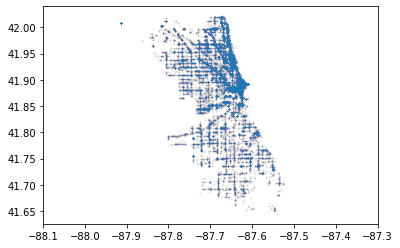

In [35]:
plt.scatter(data['Longitude'], data['Latitude'], alpha=0.005, s = 2)
plt.xlim([-88.1, -87.3])
pass

![изображение Чикаго на карте](chicago.png "Чикаго на карте")

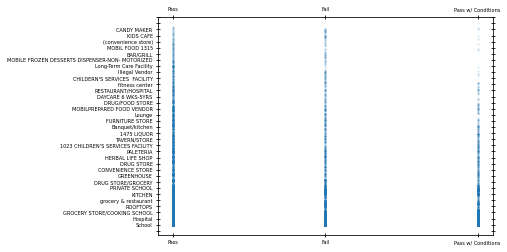

In [36]:
#plt.figure(figsize = (6, 55))
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

plt.scatter(data['Results'], data['Facility Type'], alpha=0.1, s=2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(15))

ax.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика             
               labelsize = 5,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу
               top = True,    #   сверху
               left = True,    #  слева
               right = True,    #  и справа
               labelbottom = True,    #  Рисуем подписи снизу
               labeltop = True,    #  сверху
               labelleft = True)    #  слева
pass

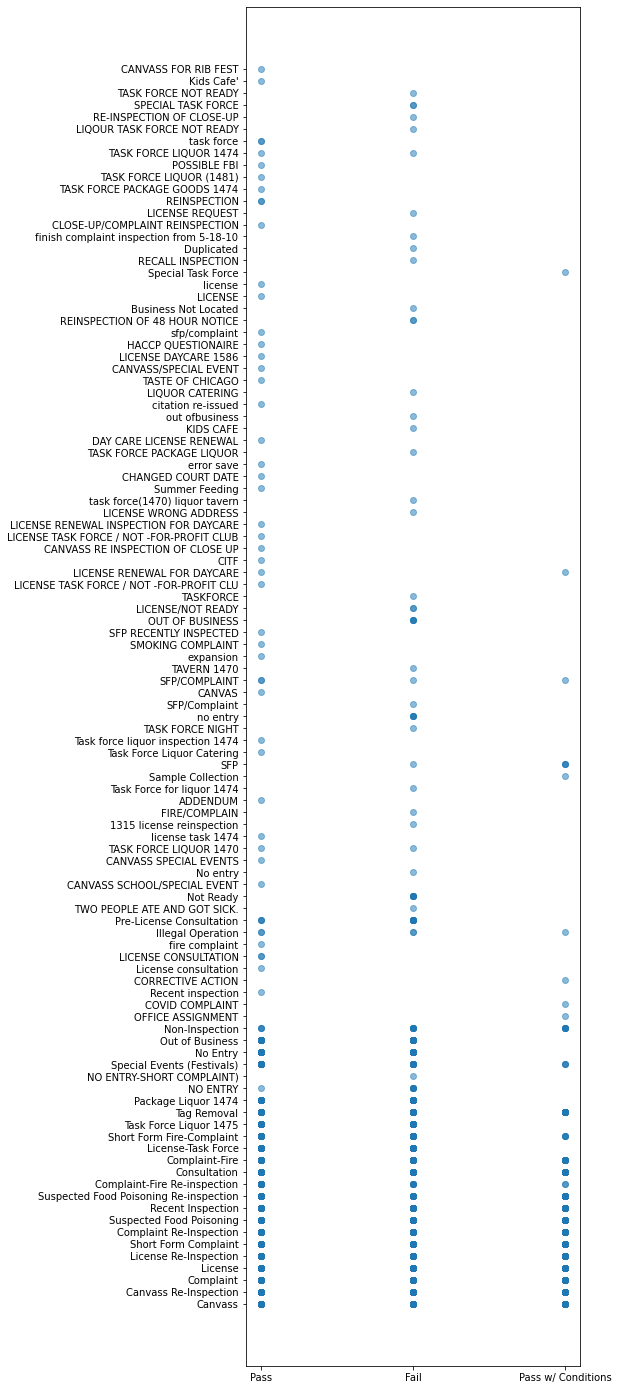

In [37]:
plt.figure(figsize = (6, 25))
plt.scatter(data['Results'], data['Inspection Type'], alpha=0.5)
pass

In [38]:
data['Inspection Date'] = pd.to_datetime(data['Inspection Date'])
data['Inspection Date']

0        2021-03-15
11       2020-11-27
12       2020-11-05
15       2020-10-22
16       2020-10-20
            ...    
221463   2010-02-26
221464   2010-02-19
221465   2010-01-12
221466   2010-03-10
221467   2010-02-01
Name: Inspection Date, Length: 191394, dtype: datetime64[ns]

Можно ещё попробовать сделать график с тремя результатами и датой проверки.
И heatmap соотношения риска к результату

In [39]:
data.describe()

,Inspection ID,License #,Risk,Zip,Latitude,Longitude,3.,10.,16.,35.,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
count,1.913940e+05,1.913940e+05,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,...,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000,191394.000000
mean,1.536524e+06,1.629538e+06,1.336468,60628.887969,41.880408,-87.676149,0.121012,0.050190,0.039975,0.332800,...,0.016934,0.003710,0.000784,0.007482,0.033538,0.002759,0.000773,0.002889,0.002074,0.000104
std,6.825548e+05,9.128013e+05,0.606809,43.357785,0.080992,0.059119,0.326142,0.218337,0.195901,0.471217,...,0.129023,0.060794,0.027984,0.086174,0.180038,0.052451,0.027797,0.053675,0.045497,0.010222
min,4.424700e+04,0.000000e+00,1.000000,46319.000000,41.644670,-87.914428,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.174213e+06,1.242927e+06,1.000000,60614.000000,41.831186,-87.706896,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.537654e+06,2.002631e+06,1.000000,60625.000000,41.891265,-87.665567,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.136072e+06,2.283348e+06,2.000000,60643.000000,41.939466,-87.634580,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.521547e+06,9.999999e+06,3.000000,60827.000000,42.021064,-87.525094,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
corr_mat = data.corr()
corr_mat

,Inspection ID,License #,Risk,Zip,Latitude,Longitude,3.,10.,16.,35.,...,24.,13.,7.,26.,42.,4.,17.,70.,27.,63.
Inspection ID,1.000000,0.244407,-0.077230,0.001959,0.046212,-0.010390,0.224880,0.234632,0.070636,-0.233007,...,-0.050360,-0.011778,0.002482,-0.040432,-0.048775,-0.052954,0.005803,-0.032402,-0.018561,0.011651
License #,0.244407,1.000000,0.080675,-0.012732,0.001094,0.036991,0.066824,0.034959,0.006578,-0.156933,...,0.005098,-0.016228,-0.002505,-0.033039,-0.009871,-0.022545,0.003298,-0.003156,-0.015767,0.004657
Risk,-0.077230,0.080675,1.000000,-0.018949,-0.094507,-0.005354,-0.064654,-0.011480,-0.037857,-0.057864,...,0.012780,0.006105,-0.002298,0.013107,-0.033133,-0.010778,-0.006442,0.021164,0.005568,-0.003141
Zip,0.001959,-0.012732,-0.018949,1.000000,0.076232,-0.173142,0.003025,0.000274,0.001482,0.011820,...,0.006160,0.002610,-0.001456,-0.001029,-0.007993,-0.000342,-0.001289,0.003635,0.002878,-0.000433
Latitude,0.046212,0.001094,-0.094507,0.076232,1.000000,-0.424562,0.024215,-0.006301,0.055677,-0.047278,...,0.001367,-0.003465,0.003382,-0.036760,0.020433,0.021931,-0.003626,0.004977,-0.018145,-0.001975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.,-0.052954,-0.022545,-0.010778,-0.000342,0.021931,0.008163,0.025383,-0.002053,0.021302,0.022256,...,0.017803,0.014815,-0.001473,0.008149,0.028933,1.000000,0.005704,0.028719,-0.000208,-0.000538
17.,0.005803,0.003298,-0.006442,-0.001289,-0.003626,0.002059,0.016765,0.000492,0.016391,0.009073,...,0.000719,0.001394,0.005938,0.001947,0.014654,0.005704,1.000000,0.012510,0.002863,-0.000284
70.,-0.032402,-0.003156,0.021164,0.003635,0.004977,-0.000191,-0.001170,-0.004349,0.012866,0.041514,...,0.033676,0.027138,-0.001508,0.004363,0.006733,0.028719,0.012510,1.000000,0.033918,-0.000550
27.,-0.018561,-0.015767,0.005568,0.002878,-0.018145,0.002029,-0.006705,-0.009428,0.003593,0.025072,...,0.026949,0.010441,0.011034,0.037354,0.002989,-0.000208,0.002863,0.033918,1.000000,-0.000466


Посмотрим более-менее значимые корреляции

In [41]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

3.   5.     0.572027
55.  49.    0.508977
58.  5.     0.506549
dtype: float64

Значит, некоторые пары нарушений совместно встречаются чаще

In [42]:
corr_mat.where(np.triu(corr_mat < -0.3, k=1)).stack().sort_values(ascending=False)

Latitude  Longitude   -0.424562
dtype: float64

Вероятно, долгота убывает при росте широты, поскольку город ориентирован не строго с севера на юг, а слегка на юго-восток.

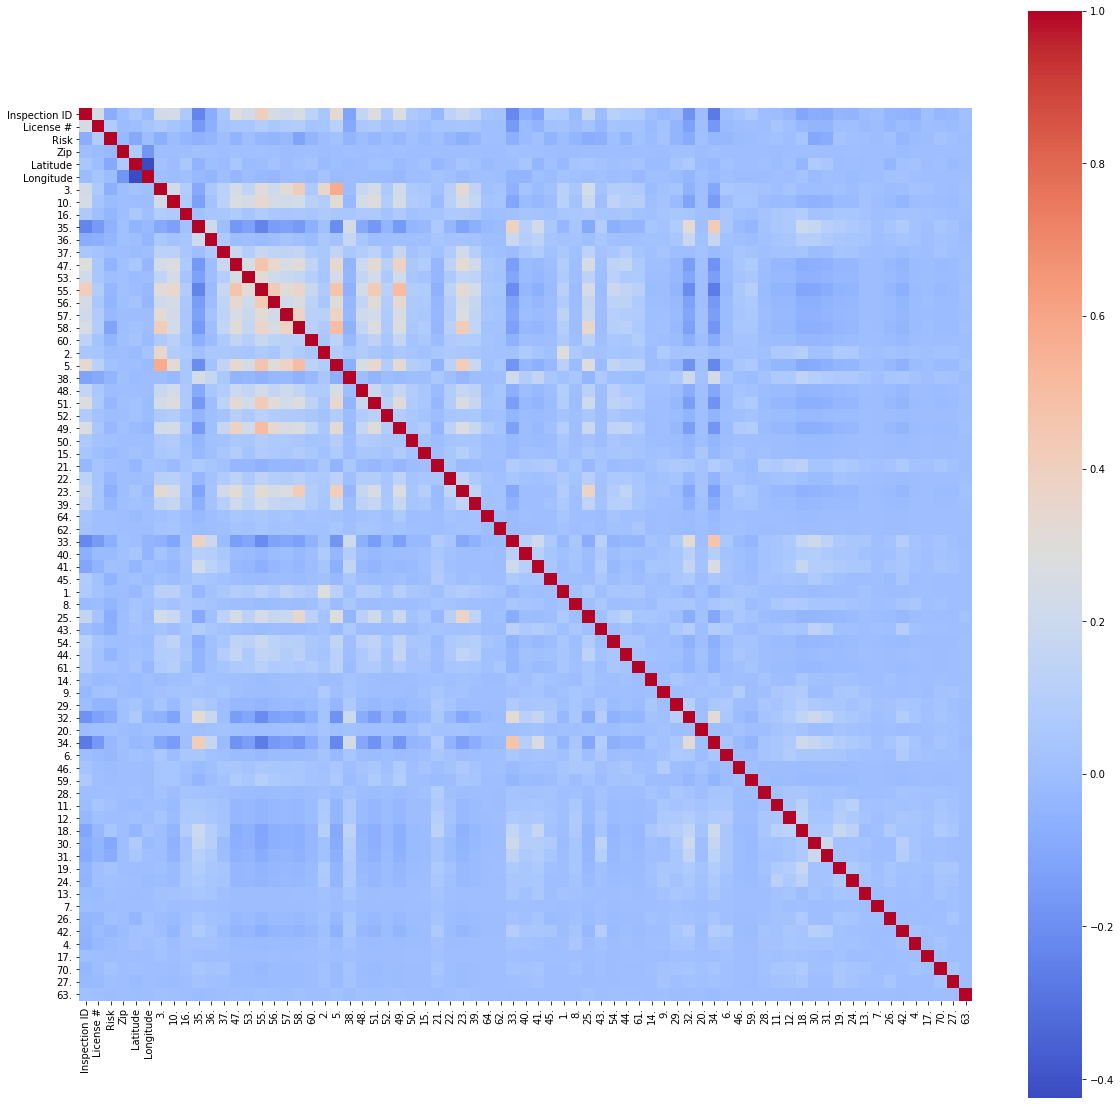

In [43]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

## Бинаризация

In [44]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['DBA Name', 'AKA Name', 'Address', 'City', 'State']
['Inspection ID', 'License #', 'Facility Type', 'Risk', 'Zip', 'Inspection Date', 'Inspection Type', 'Results', 'Latitude', 'Longitude', '3.', '10.', '16.', '35.', '36.', '37.', '47.', '53.', '55.', '56.', '57.', '58.', '60.', '2.', '5.', '38.', '48.', '51.', '52.', '49.', '50.', '15.', '21.', '22.', '23.', '39.', '64.', '62.', '33.', '40.', '41.', '45.', '1.', '8.', '25.', '43.', '54.', '44.', '61.', '14.', '9.', '29.', '32.', '20.', '34.', '6.', '46.', '59.', '28.', '11.', '12.', '18.', '30.', '31.', '19.', '24.', '13.', '7.', '26.', '42.', '4.', '17.', '70.', '27.', '63.']


In [45]:
data_describe = data.describe(include = [object])

In [46]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

[] ['DBA Name', 'AKA Name', 'Address', 'City', 'State']


In [47]:
for c in categorical_columns:
    print(c, data[c].unique())

DBA Name ['Kozminski' 'SUBWAY' 'DYETT HIGH SCHOOL' ... 'A1 GROCERY'
 'COUSCOUS HOUSE' 'RIB PALACE']
AKA Name ['Kozminski' 'SUBWAY' 'DYETT HIGH SCHOOL' ... 'A1 GROCERY'
 'COUSCOUS HOUSE' 'COOKTEK PASTRY #1']
Address ['936 E 54th St (5400S) ' '4406 S PULASKI RD ' '555 E 51st St(5100S) ' ...
 '2301 N Clark ST ' '1800 E 79TH ST BLDG ' '375 E 75TH ST ']
City ['CHICAGO' 'NILES NILES' 'OAK PARK' 'Chicago' 'MAYWOOD' 'SCHAUMBURG'
 'CALUMET CITY' 'BLOOMINGDALE' 'CICERO' 'chicago' 'SKOKIE' 'EVANSTON'
 'BOLINGBROOK' 'LAKE ZURICH' 'WORTH' 'CHARLES A HAYES' 'ALSIP' 'CCHICAGO'
 'CHicago' 'CHICAGOC' 'MORTON GROVE' '312CHICAGO' 'CHICAGOHICAGO'
 'CHICAGOCHICAGO' 'BRIDGEVIEW' 'NEW HOLSTEIN' 'GRIFFITH' 'ELMHURST'
 'CHICAGO.' 'ALGONQUIN' 'LANSING' 'WHEATON' 'WADSWORTH' 'ROSEMONT'
 'PLAINFIELD' 'PALOS PARK' 'HIGHLAND PARK' 'ELK GROVE VILLAGE'
 'LAKE BLUFF' 'SCHILLER PARK' 'BANNOCKBURNDEERFIELD' 'Norridge'
 'CHCHICAGO' 'COUNTRY CLUB HILLS' 'CHICAGO HEIGHTS' 'JUSTICE' 'SUMMIT'
 'TINLEY PARK' 'EAST HAZEL CREST